In [1]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator


df = pd.read_csv("CVD_cleaned.csv")
print(f'dfset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

dfset contains 308854 rows and 19 columns


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


# Dataset Column Descriptions

- **Exercise**: Indicates whether the individual participates in physical activity (e.g. "Yes" or "No").

- **Heart_Disease**: Reports if the individual has been diagnosed with heart disease.

- **Depression**: Indicates whether the individual has been diagnosed with depression.

- **Diabetes**: Reports the diabetes status. It may include simple "Yes"/"No" values or more detailed categories.

- **Arthritis**: Indicates if the individual has arthritis.

- **Sex**: The gender of the individual (e.g. "Male" or "Female").

- **Age_Category**: Categorical representation of the age range of the individual (e.g. "70-74", "80+").

- **Height_(cm)**: The height of the individual measured in centimeters.

- **Weight_(kg)**: The weight of the individual measured in kilograms.

- **BMI**: Body Mass Index calculated from height and weight, providing an estimate of body fat.

- **Smoking_History**: Indicates whether the individual has a history of smoking.

- **Alcohol_Consumption**: A measure of the individual's alcohol intake; it is later discretized into categories (e.g. "Low" or "High").

- **Fruit_Consumption**: A measure of the amount of fruit consumed, later categorized (e.g. "Low" or "High").

- **Green_Vegetables_Consumption**: Indicates the consumption level of green vegetables, categorized for analysis.

- **FriedPotato_Consumption**: Reports the consumption level of fried potatoes, discretized into categories.

- **Cancer**: A derived column that indicates the occurrence of any cancer; it is set to "Yes" if either skin cancer or another form of cancer was reported, and "No" otherwise.


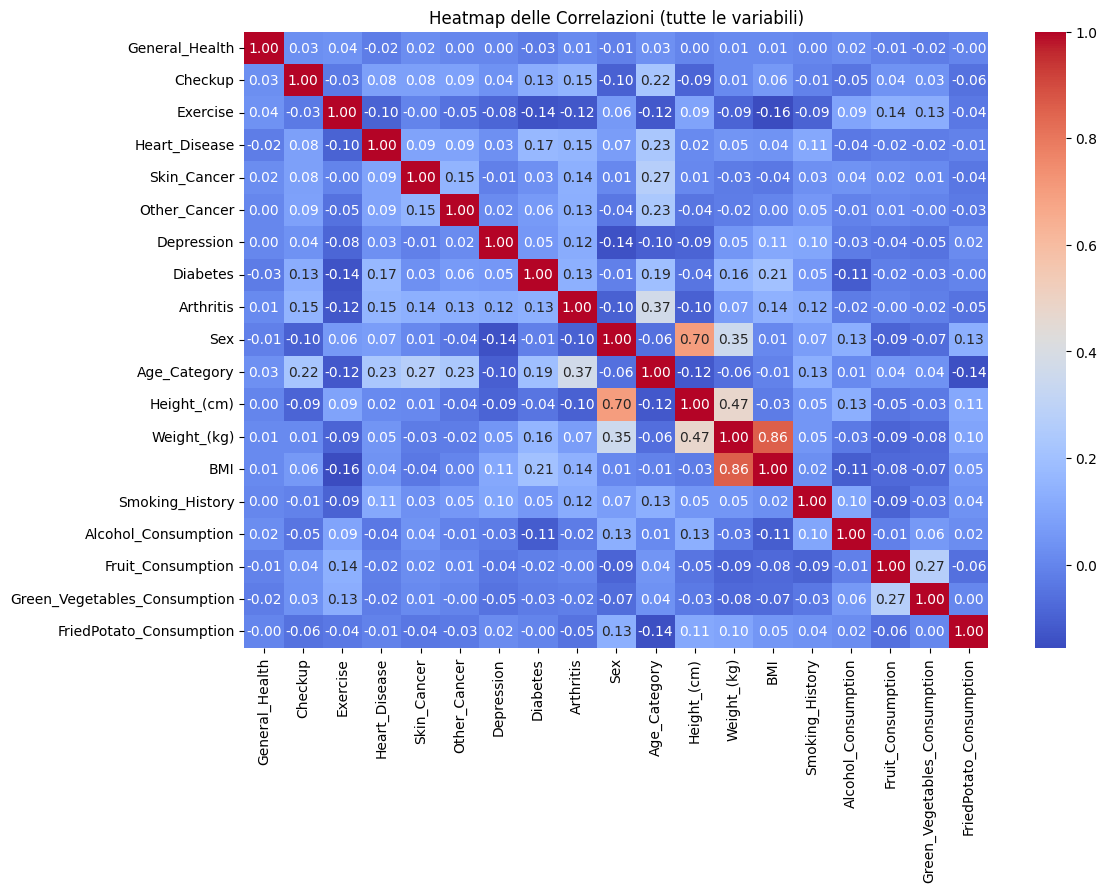

In [ ]:
# Create a temporary DataFrame to avoid modifying the original
df_temp = df.copy()

# --- Convert categorical variables to numerical codes
# This is necessary for correlation calculation
# and for the Bayesian model
for col in df_temp.select_dtypes(include=['object']).columns:
    df_temp[col] = df_temp[col].astype('category').cat.codes

# Calculate and show the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap delle Correlazioni (tutte le variabili)")
plt.show()

In [ ]:
# Removes 'General_Health' and 'Checkup'
df.drop(columns=['General_Health', 'Checkup'], inplace=True)

# --- Create a new column 'Cancer' based on 'Skin_Cancer' and 'Other_Cancer'
df['Cancer'] = df.apply(lambda row: 'Yes' if row['Skin_Cancer'] == 'Yes' or row['Other_Cancer'] == 'Yes' else 'No', axis=1)

# Removes 'Skin_Cancer' and 'Other_Cancer' columns
df.drop(columns=['Skin_Cancer', 'Other_Cancer'], inplace=True)

print(len(df.columns))
df.columns

16


Index(['Exercise', 'Heart_Disease', 'Depression', 'Diabetes', 'Arthritis',
       'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI',
       'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption', 'Cancer'],
      dtype='object')

In [5]:
# cols_to_discretize = [
#     'Height_(cm)',
#     'Weight_(kg)',
#     'BMI',
#     'Alcohol_Consumption',
#     'Fruit_Consumption',
#     'Green_Vegetables_Consumption',
#     'FriedPotato_Consumption',
# ]

# for col in cols_to_discretize:
#     plt.figure(figsize=(12, 6))
#     ax = sns.countplot(x=df[col])
#     ticks = ax.get_xticks()
#     ax.set_xticks(ticks[::40])
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Count')
#     plt.show()

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
colonne = ['Height_(cm)', 'Weight_(kg)', 'BMI']

# Initialize the discretizer
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')

# Apply the discretizer to the specified columns
df_disc = df.copy()
df_disc[colonne] = discretizer.fit_transform(df[colonne])

# Discretize 'Alcohol_Consumption'
df_disc['Alcohol_Consumption'] = pd.cut(
    df['Alcohol_Consumption'], bins=[-float('inf'), 2.0, float('inf')], labels=['Low', 'High']
)

# Discretize 'Fruit_Consumption'
df_disc['Fruit_Consumption'] = pd.cut(
    df['Fruit_Consumption'], bins=[-float('inf'), 15.0, float('inf')], labels=['Low', 'High']
)

# Discretize 'Green_Vegetables_Consumption'
df_disc['Green_Vegetables_Consumption'] = pd.cut(
    df['Green_Vegetables_Consumption'], bins=[-float('inf'), 16.0, float('inf')], labels=['Low', 'High']
)

# Discretize 'FriedPotato_Consumption'
df_disc['FriedPotato_Consumption'] = pd.cut(
    df['FriedPotato_Consumption'], bins=[-float('inf'), 10.0, float('inf')], labels=['Low', 'High']
)

In [ ]:
# Show the distribution of the discretized columns
discretized_columns = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

for col in discretized_columns:
    print(f"Distribuzione per la colonna '{col}':")
    print(df_disc[col].value_counts())
    print("\n")

Distribuzione per la colonna 'Height_(cm)':
Height_(cm)
3.0    96973
1.0    76605
2.0    70514
0.0    64762
Name: count, dtype: int64


Distribuzione per la colonna 'Weight_(kg)':
Weight_(kg)
1.0    83550
3.0    80225
2.0    76182
0.0    68897
Name: count, dtype: int64


Distribuzione per la colonna 'BMI':
BMI
2.0    79180
3.0    77560
1.0    76076
0.0    76038
Name: count, dtype: int64


Distribuzione per la colonna 'Alcohol_Consumption':
Alcohol_Consumption
Low     184985
High    123869
Name: count, dtype: int64


Distribuzione per la colonna 'Fruit_Consumption':
Fruit_Consumption
High    203710
Low     105144
Name: count, dtype: int64


Distribuzione per la colonna 'Green_Vegetables_Consumption':
Green_Vegetables_Consumption
Low     214976
High     93878
Name: count, dtype: int64


Distribuzione per la colonna 'FriedPotato_Consumption':
FriedPotato_Consumption
Low     254460
High     54394
Name: count, dtype: int64




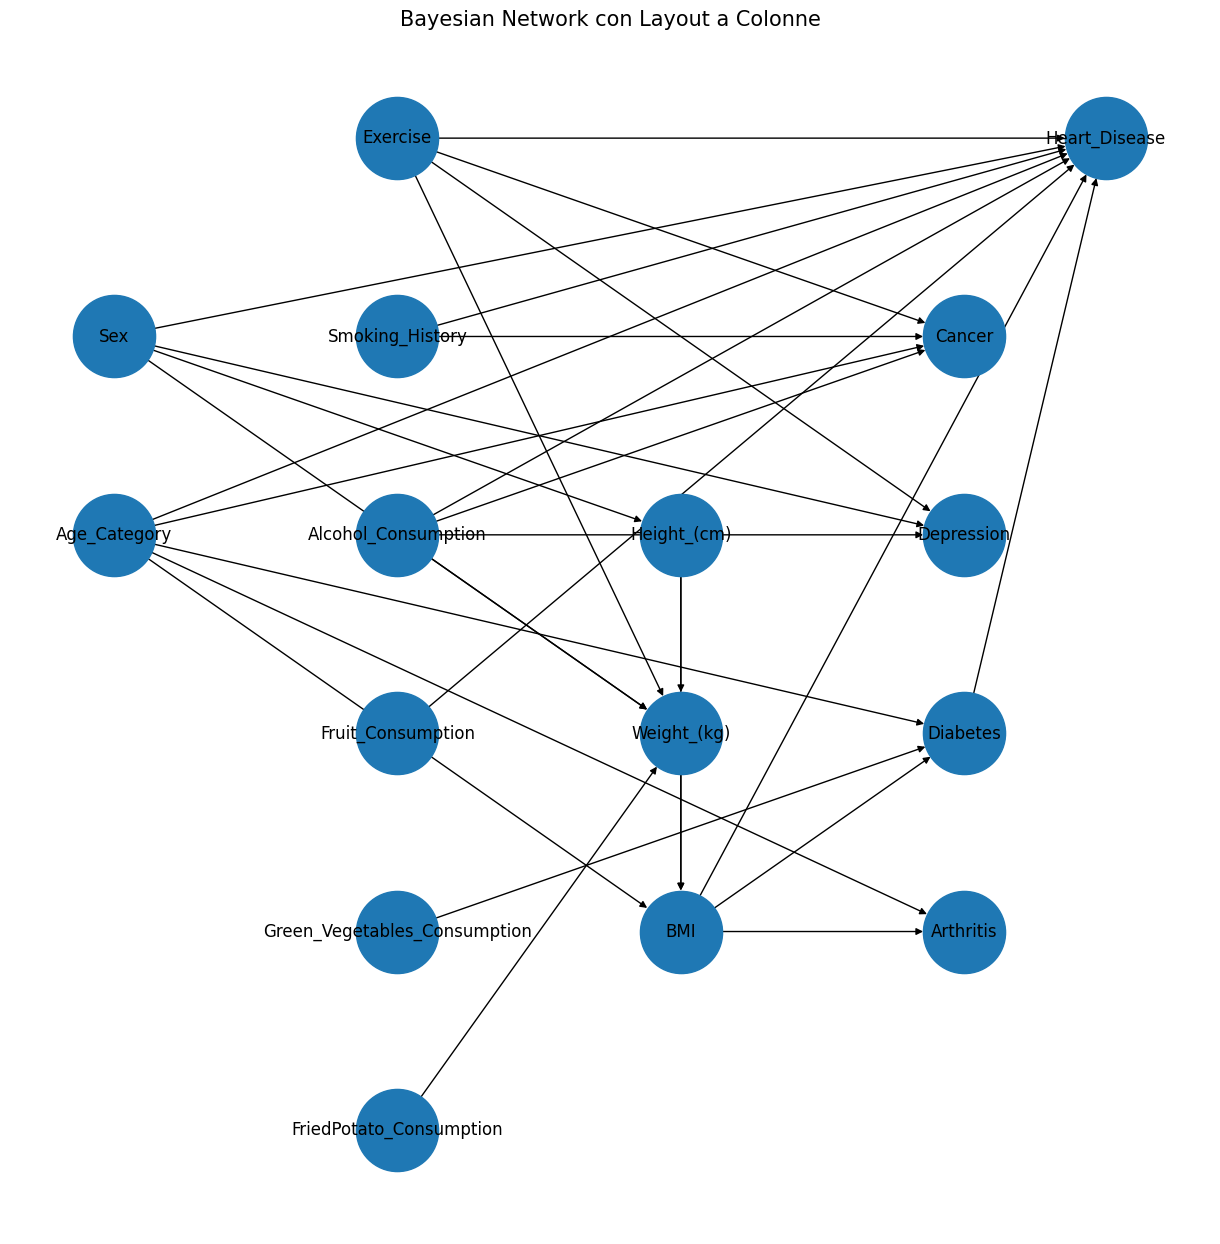

In [ ]:
custom_model = BayesianModel([
    ('Height_(cm)', 'Weight_(kg)'),
    ('Height_(cm)', 'BMI'),
    ('Weight_(kg)', 'BMI'),

    ('Sex', 'Heart_Disease'),
    ('Sex', 'Depression'),
    ('Sex', 'Weight_(kg)'),
    ('Sex', 'Height_(cm)'),
    ('Age_Category', 'Heart_Disease'),
    ('Age_Category', 'Diabetes'),
    ('Age_Category', 'Arthritis'),
    ('Age_Category', 'BMI'),
    ('Age_Category', 'Cancer'),

    ('Smoking_History', 'Heart_Disease'),
    ('Smoking_History', 'Cancer'),

    ('Alcohol_Consumption', 'Heart_Disease'),
    ('Alcohol_Consumption', 'Cancer'),
    ('Alcohol_Consumption', 'Depression'),
    ('Alcohol_Consumption', 'Weight_(kg)'),
    ('Fruit_Consumption', 'Heart_Disease'),
    ('Green_Vegetables_Consumption', 'Diabetes'),
    ('FriedPotato_Consumption', 'Weight_(kg)'),
    ('Exercise', 'Heart_Disease'),
    ('Exercise', 'Depression'),
    ('Exercise', 'Weight_(kg)'),
    ('Exercise', 'Cancer'),

    ('BMI', 'Heart_Disease'),
    ('BMI', 'Diabetes'),
    ('BMI', 'Arthritis'),

    ('Diabetes', 'Heart_Disease'),
])



pos = {
    # Column 1: Demographics
    'Sex': (0, 3),
    'Age_Category': (0, 2),

    # Column 2: Lifestyle
    'Exercise': (2, 4),
    'Smoking_History': (2, 3),
    'Alcohol_Consumption': (2, 2),
    'Fruit_Consumption': (2, 1),
    'Green_Vegetables_Consumption': (2, 0),
    'FriedPotato_Consumption': (2, -1),

    # Column 3: Health Metrics
    'Height_(cm)': (4, 2),
    'Weight_(kg)': (4, 1),
    'BMI': (4, 0),

    # Column 4: Health Conditions
    'Heart_Disease': (7, 4),
    'Cancer': (6, 3),
    'Depression': (6, 2),
    'Diabetes': (6, 1),
    'Arthritis': (6, 0),
}

# Create a directed graph from the Bayesian model
plt.figure(figsize=(12, 12))
G = nx.DiGraph(custom_model.edges())
nx.draw(G, pos, with_labels=True, node_size=3500)

plt.title("Bayesian Network con Layout a Colonne", fontsize=15)
plt.axis("off")
plt.show()


Building tree:   0%|          | 0/120.0 [00:00<?, ?it/s]

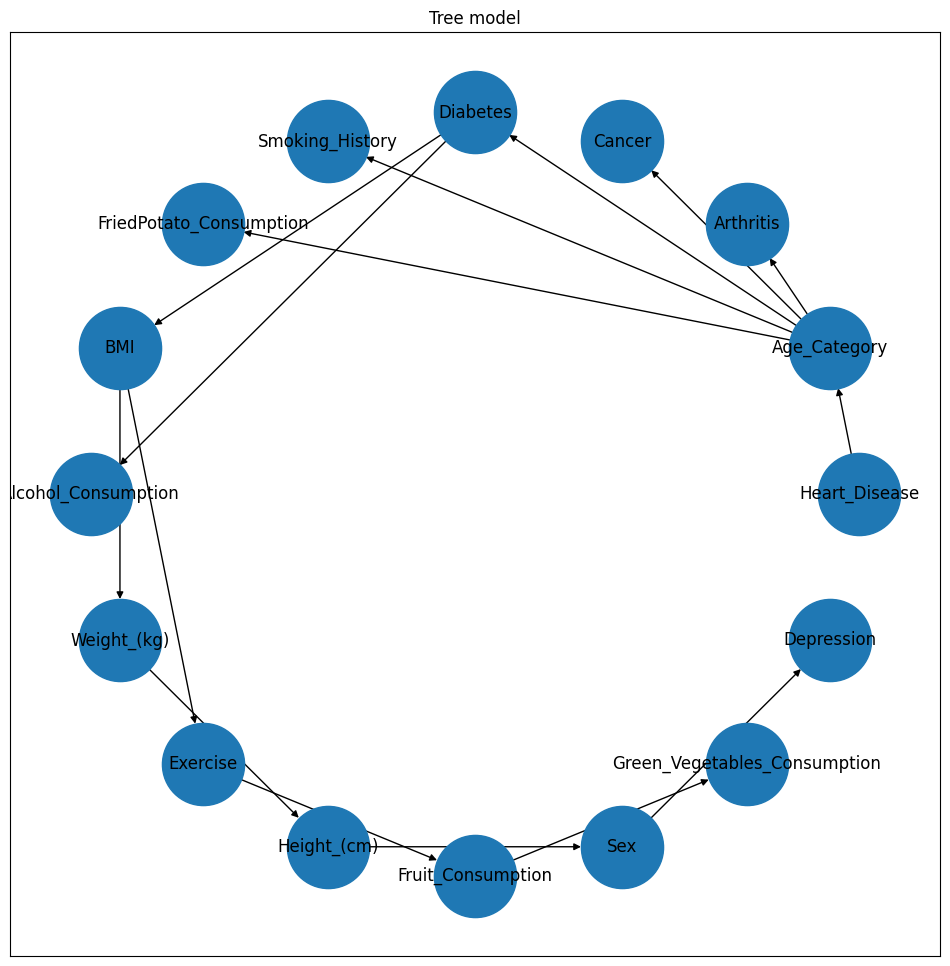

In [ ]:
# Tree Search Model

ts = TreeSearch(data=df_disc, root_node='Heart_Disease')
# ts = TreeSearch(data=df_disc)
tree_model = ts.estimate()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=3500)
ax.set_title('Tree model')
tree_model = BayesianModel(tree_model.edges())

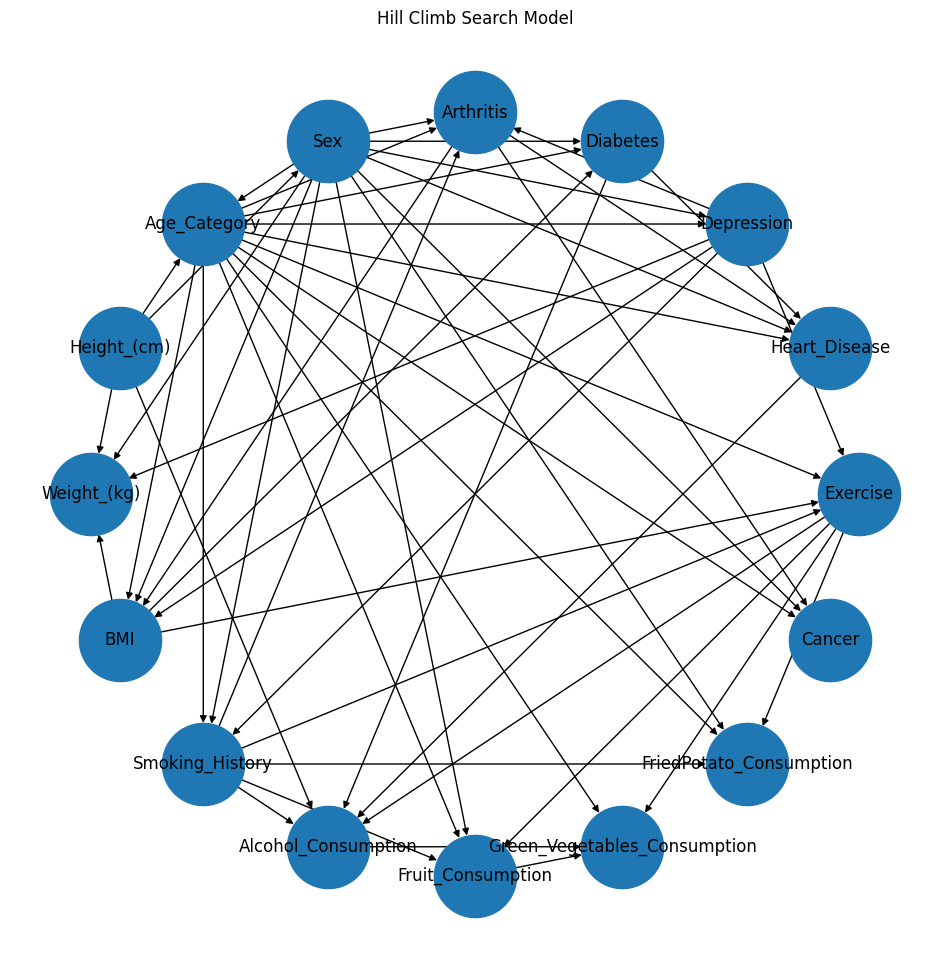

In [ ]:
# Hill Climb Search Model
scorer = BDeuScore(data=df_disc)

hc = HillClimbSearch(data=df_disc)

hc_model = hc.estimate(scoring_method=scorer, show_progress=False)

plt.figure(figsize=(12, 12))
pos_hc = nx.drawing.layout.circular_layout(hc_model)
nx.draw_networkx(hc_model, pos=pos_hc, node_size=3500, with_labels=True, arrows=True)
plt.title('Hill Climb Search Model')
plt.axis('off')
plt.show()

hc_model_bayes = BayesianModel(hc_model.edges())

In [ ]:
# Compute CPDs for all models

models = [('custom', custom_model), ('tree', tree_model), ('hc', hc_model_bayes)]
for name, model in models:
    print(f'Computing CPDs for {name} model')
    model.fit(df_disc, estimator=MaximumLikelihoodEstimator)

Computing CPDs for custom model


Computing CPDs for tree model
Computing CPDs for hc model


# Questions

In [22]:
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt

# Create inference objects for both models
infer_custom = VariableElimination(custom_model)
infer_tree = VariableElimination(tree_model)
infer_hc = VariableElimination(hc_model_bayes)


## Query 1:
"What's the probability of developing a cardiac disease given that the patient is non smoker and athletic?"

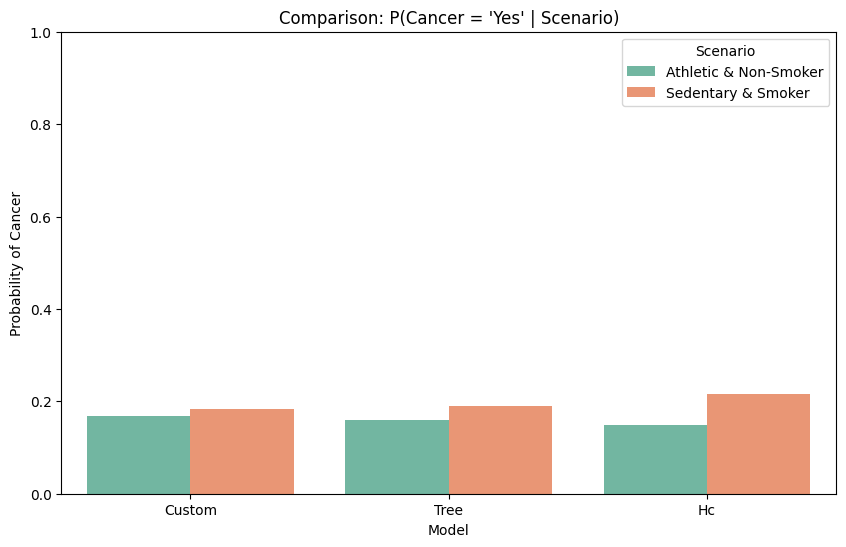

In [23]:
# Definition of scenarios to compare
scenarios = {
    "Athletic & Non-Smoker": {'Smoking_History': 'No', 'Exercise': 'Yes'},
    "Sedentary & Smoker": {'Smoking_History': 'Yes', 'Exercise': 'No'}
}

# List of models
models = {
    'Custom': infer_custom,
    'Tree': infer_tree,
    'Hc': infer_hc
}

# Perform queries and collect results
data = []
for scenario_label, evidence in scenarios.items():
    for model_label, model in models.items():
        result = model.query(variables=['Cancer'], evidence=evidence)
        try:
            states = result.state_names['Cancer']
        except (AttributeError, KeyError):
            states = ['No', 'Yes']
        for state, prob in zip(states, result.values):
            data.append({
                'Scenario': scenario_label,
                'Model': model_label,
                'Cancer': state,
                'Probability': prob
            })

# Create a DataFrame for visualization
df_plot = pd.DataFrame(data)

# Filter only the probability of Cancer = 'Yes'
df_yes = df_plot[df_plot['Cancer'] == 'Yes']

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df_yes, x='Model', y='Probability', hue='Scenario', ci=None, palette="Set2", dodge=True)
plt.title("Comparison: P(Cancer = 'Yes' | Scenario)")
plt.ylim(0, 1)
plt.ylabel("Probability of Cancer")
plt.show()

## Query 2:
"What is the combined effect of factors such as alcohol consumption, diet (fruit, vegetables, and fried potatoes) and physical activity on the probability of developing hearth deseases?"

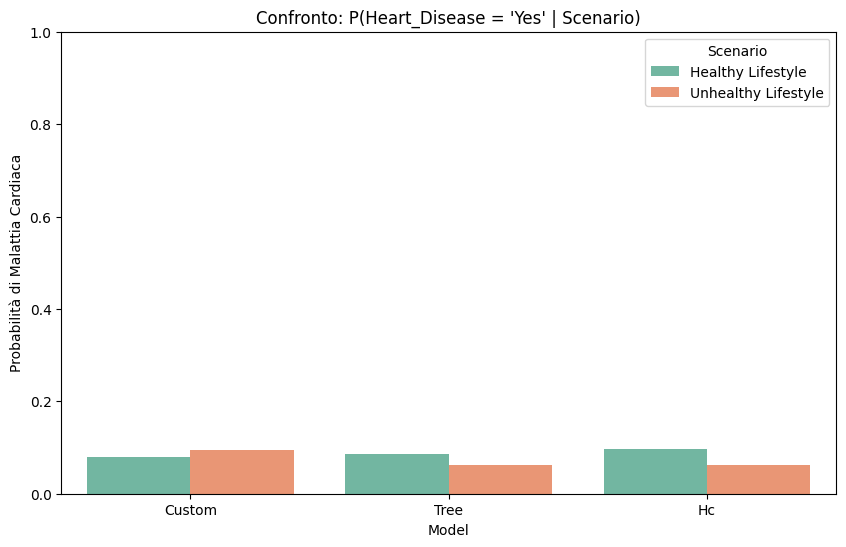

In [ ]:
def new_func():
    # Defines the scenarios to compare
    scenarios_heart_disease = {
        "Healthy Lifestyle": {
            'Exercise': 'Yes',
            'Alcohol_Consumption': 'Low',
            'Fruit_Consumption': 'High',
            'Green_Vegetables_Consumption': 'High',
            'FriedPotato_Consumption': 'Low'
        },
        "Unhealthy Lifestyle": {
            'Exercise': 'No',
            'Alcohol_Consumption': 'High',
            'Fruit_Consumption': 'Low',
            'Green_Vegetables_Consumption': 'Low',
            'FriedPotato_Consumption': 'High'
        }
    }

    # Executes the queries and collects the results
    data_heart_disease = []
    for scenario_label, evidence in scenarios_heart_disease.items():
        for model_label, model in models.items():
            result = model.query(variables=['Heart_Disease'], evidence=evidence)
            try:
                states = result.state_names['Heart_Disease']
            except (AttributeError, KeyError):
                states = ['No', 'Yes']
            for state, prob in zip(states, result.values):
                data_heart_disease.append({
                    'Scenario': scenario_label,
                    'Model': model_label,
                    'Heart_Disease': state,
                    'Probability': prob
                })

    # Creates a DataFrame for visualization
    df_heart_disease_plot = pd.DataFrame(data_heart_disease)

    # Filters only the probability of Heart_Disease = 'Yes'
    df_heart_disease_yes = df_heart_disease_plot[df_heart_disease_plot['Heart_Disease'] == 'Yes']

    # Plots the grouped bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_heart_disease_yes, x='Model', y='Probability', hue='Scenario', ci=None, palette="Set2", dodge=True)
    plt.title("Confronto: P(Heart_Disease = 'Yes' | Scenario)")
    plt.ylim(0, 1)
    plt.ylabel("Probabilità di Malattia Cardiaca")
    plt.show()

new_func()

Associazione vs causalità: questi modelli imparano dipendenze statistiche osservazionali, non “effetti di intervento” (do-calculus). Se ad esempio chi ha già una cardiopatia tende a mangiare più frutta o fare più esercizio (perché glielo ha prescritto il medico), il modello vedrà proprio in “stile di vita sano” un marcatore di malattia!

## Query 3
"How does the consumption of fruit, vegetables (particularly green ones), and fried potatoes influence the likelihood of developing diabetes?"

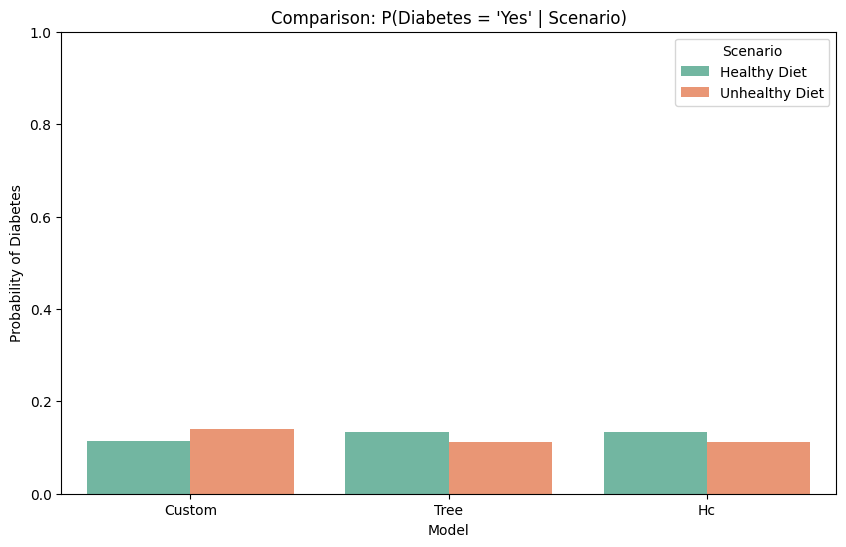

In [15]:
# Define scenarios to compare
scenarios_diabetes = {
    "Healthy Diet": {
        'Fruit_Consumption': 'High',
        'Green_Vegetables_Consumption': 'High',
        'FriedPotato_Consumption': 'Low'
    },
    "Unhealthy Diet": {
        'Fruit_Consumption': 'Low',
        'Green_Vegetables_Consumption': 'Low',
        'FriedPotato_Consumption': 'High'
    }
}

# Perform queries for each model and collect results
data_diabetes = []
for scenario_label, evidence in scenarios_diabetes.items():
    for model_label, model in models.items():
        result = model.query(variables=['Diabetes'], evidence=evidence)
        try:
            states = result.state_names['Diabetes']
        except (AttributeError, KeyError):
            states = ['No', 'Yes']
        for state, prob in zip(states, result.values):
            data_diabetes.append({
                'Scenario': scenario_label,
                'Model': model_label,
                'Diabetes': state,
                'Probability': prob
            })

# Create a DataFrame for visualization
df_diabetes_plot = pd.DataFrame(data_diabetes)

# Filter only the probability of Diabetes = 'Yes'
df_diabetes_yes = df_diabetes_plot[df_diabetes_plot['Diabetes'] == 'Yes']

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df_diabetes_yes, x='Model', y='Probability', hue='Scenario', ci=None, palette="Set2", dodge=True)
plt.title("Comparison: P(Diabetes = 'Yes' | Scenario)")
plt.ylim(0, 1)
plt.ylabel("Probability of Diabetes")
plt.show()

## Query 4
"Does a person's sex influence the risk of developing diabetes?"

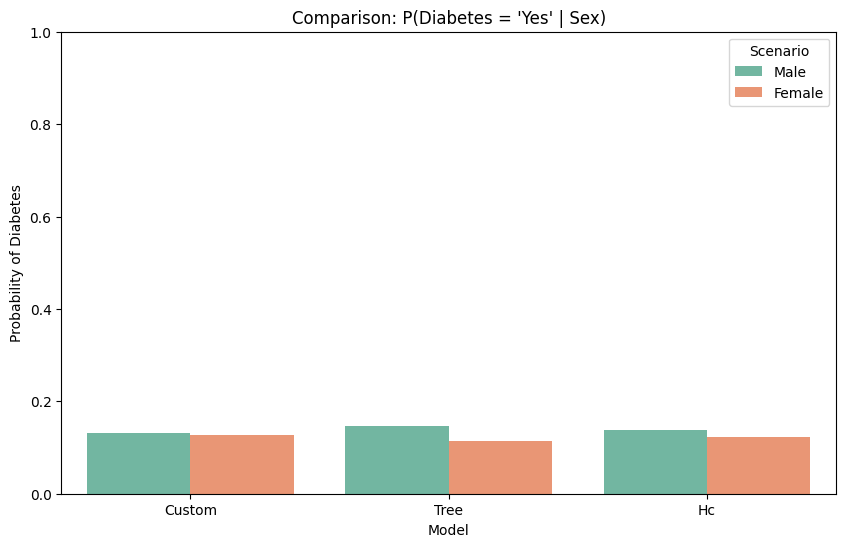

In [16]:
# Define scenarios for different sexes
scenarios_sex = {
    "Male": {'Sex': 'Male'},
    "Female": {'Sex': 'Female'}
}

# Perform queries for each model and collect results
data_sex_diabetes = []
for scenario_label, evidence in scenarios_sex.items():
    for model_label, model in models.items():
        result = model.query(variables=['Diabetes'], evidence=evidence)
        try:
            states = result.state_names['Diabetes']
        except (AttributeError, KeyError):
            states = ['No', 'Yes']
        for state, prob in zip(states, result.values):
            data_sex_diabetes.append({
                'Scenario': scenario_label,
                'Model': model_label,
                'Diabetes': state,
                'Probability': prob
            })

# Create a DataFrame for visualization
df_sex_diabetes_plot = pd.DataFrame(data_sex_diabetes)

# Filter only the probability of Diabetes = 'Yes'
df_sex_diabetes_yes = df_sex_diabetes_plot[df_sex_diabetes_plot['Diabetes'] == 'Yes']

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df_sex_diabetes_yes, x='Model', y='Probability', hue='Scenario', ci=None, palette="Set2", dodge=True)
plt.title("Comparison: P(Diabetes = 'Yes' | Sex)")
plt.ylim(0, 1)
plt.ylabel("Probability of Diabetes")
plt.show()